In [1]:
import numpy as np
import librosa
import os
from os import walk
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import pandas as pd

In [2]:
import librosa
import numpy as np

def get_chroma_vector(wav_file_path, target_duration=3):
    y, sr = librosa.load(wav_file_path, sr=None)
    current_duration = librosa.get_duration(y=y, sr=sr)
    
    # Calculez le facteur d'étirement ou de compression nécessaire
    time_stretch_factor = current_duration / target_duration
    
    # Étirez ou compressez le signal audio pour atteindre la durée cible
    y_stretched = librosa.effects.time_stretch(y,rate=time_stretch_factor)
    
    # Calculez le chromagramme à partir du signal modifié
    chroma = np.array(librosa.feature.chroma_stft(y=y_stretched, sr=sr))

    df_chroma = pd.DataFrame(chroma)
    moyenne_par_colonne = df_chroma.mean()

    # Sélectionnez les colonnes dont la moyenne est inférieure ou égale à 0.6
    colonnes_a_conserver = moyenne_par_colonne[moyenne_par_colonne <= 0.65].index

    # Créez un nouveau DataFrame en ne conservant que les colonnes sélectionnées
    df_filtered = df_chroma[colonnes_a_conserver]

    new_chroma = df_filtered.to_numpy()
    
    return new_chroma


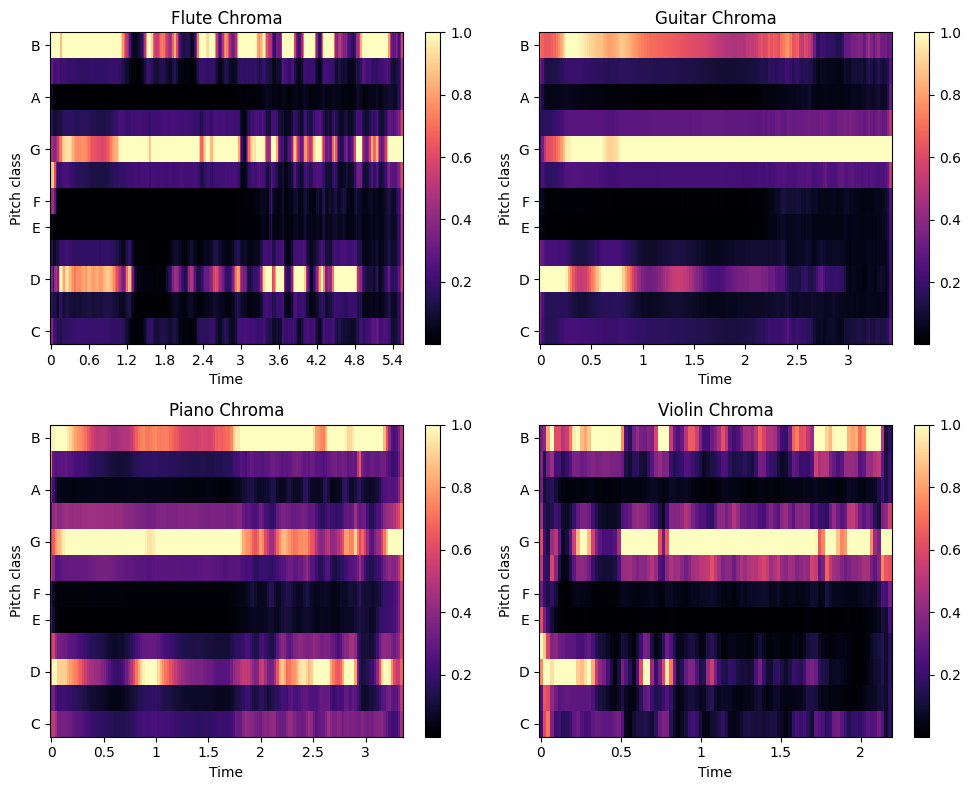

In [3]:
import matplotlib.pyplot as plt

# Obtenez les 4 chromagrammes (remplacez ces lignes par les données réelles que vous avez)
chroma1 = get_chroma_vector('Chords_generation/chords_wav/F_Gmaj.wav')
chroma2 = get_chroma_vector('Chords_generation/chords_wav/G_Gmaj.wav')
chroma3 = get_chroma_vector('Chords_generation/chords_wav/P_Gmaj.wav')
chroma4 = get_chroma_vector('Chords_generation/chords_wav/V_Gmaj.wav')

# Créez une figure avec une grille de 2x2 sous-plots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Affichez chaque chromagramme dans un sous-plot
img1 = librosa.display.specshow(chroma1, y_axis='chroma', x_axis='time', ax=axes[0, 0])
axes[0, 0].set_title('Flute Chroma')

img2 = librosa.display.specshow(chroma2, y_axis='chroma', x_axis='time', ax=axes[0, 1])
axes[0, 1].set_title('Guitar Chroma')

img3 = librosa.display.specshow(chroma3, y_axis='chroma', x_axis='time', ax=axes[1, 0])
axes[1, 0].set_title('Piano Chroma')

img4 = librosa.display.specshow(chroma4, y_axis='chroma', x_axis='time', ax=axes[1, 1])
axes[1, 1].set_title('Violin Chroma')

# Ajoutez une barre de couleur pour chaque sous-plot
fig.colorbar(img1, ax=axes[0, 0])
fig.colorbar(img2, ax=axes[0, 1])
fig.colorbar(img3, ax=axes[1, 0])
fig.colorbar(img4, ax=axes[1, 1])

# Ajustez l'espacement entre les sous-plots
plt.tight_layout()

# Affichez la figure
plt.show()


In [4]:
def get_feature(file_path):
 # Extracting chroma vector feature
  chroma = get_chroma_vector(file_path)
  chroma_mean = chroma.mean(axis=1)

  feature = chroma_mean
  return feature

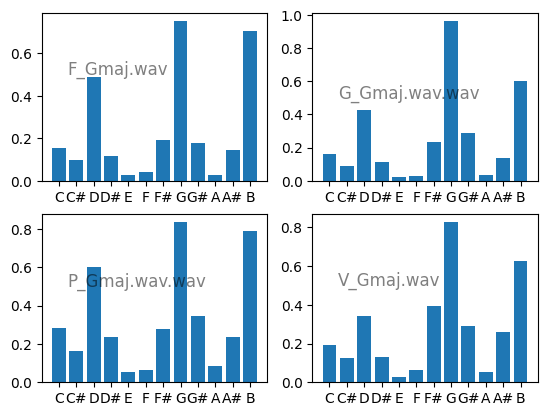

In [5]:
names = ['C', 'C#', 'D','D#','E','F','F#','G','G#','A','A#','B'] # nom des barres

values_f = get_feature('Chords_generation/chords_wav/F_Gmaj.wav').tolist()
values_g = get_feature('Chords_generation/chords_wav/G_Gmaj.wav').tolist()
values_p = get_feature('Chords_generation/chords_wav/P_Gmaj.wav').tolist()
values_v = get_feature('Chords_generation/chords_wav/V_Gmaj.wav').tolist()

plt.subplot(221)
plt.bar(names, values_f)
plt.text(0.5, 0.5, "F_Gmaj.wav", size=12, alpha=.5)

plt.subplot(222)
plt.bar(names, values_g)
plt.text(0.5,0.5, "G_Gmaj.wav.wav", size=12, alpha=.5)

plt.subplot(223)
plt.bar(names, values_p)
plt.text(0.5,0.5, "P_Gmaj.wav.wav", size=12, alpha=.5)

plt.subplot(224)
plt.bar(names, values_v)
plt.text(0.5,0.5, "V_Gmaj.wav", size=12, alpha=.5)

plt.show()


In [6]:
def extract_features(directory):
    features = []
    labels = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            feature = get_feature(file_path)
            label = file.split('_')[1].split('.')[0]
            features.append(feature)
            labels.append(label)

    return features, labels

In [7]:
dir = 'Chords_generation\chords_wav'
features, labels = extract_features(dir)

In [8]:
permutations = np.random.permutation(408)

label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

features = np.array(features)[permutations]
labels_encoded = np.array(labels_encoded)[permutations]

In [9]:
X_train, X_test, y_train, y_test = train_test_split(features, labels_encoded, test_size=0.2, random_state=42)

In [10]:
model = keras.Sequential()
model.add(keras.layers.Input(shape=(12)))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(200, activation='relu'))
model.add(keras.layers.Dense(103, activation='softmax'))
model.compile(optimizer=keras.optimizers.RMSprop(), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [18]:
history = model.fit(x=X_train,y=y_train,epochs=65,validation_split=0.2)


Epoch 1/65
9/9 [==============================] - 1s 30ms/step - loss: 1.6434 - accuracy: 0.4385 - val_loss: 1.7316 - val_accuracy: 0.4091
Epoch 2/65
9/9 [==============================] - 0s 8ms/step - loss: 1.5820 - accuracy: 0.4538 - val_loss: 1.8496 - val_accuracy: 0.2879
Epoch 3/65
9/9 [==============================] - 0s 7ms/step - loss: 1.5249 - accuracy: 0.4654 - val_loss: 1.9396 - val_accuracy: 0.3333
Epoch 4/65
9/9 [==============================] - 0s 8ms/step - loss: 1.4860 - accuracy: 0.4769 - val_loss: 1.9167 - val_accuracy: 0.3485
Epoch 5/65
9/9 [==============================] - 0s 9ms/step - loss: 1.4450 - accuracy: 0.4615 - val_loss: 1.8873 - val_accuracy: 0.3030
Epoch 6/65
9/9 [==============================] - 0s 8ms/step - loss: 1.3816 - accuracy: 0.5192 - val_loss: 1.8645 - val_accuracy: 0.3333
Epoch 7/65
9/9 [==============================] - 0s 7ms/step - loss: 1.3667 - accuracy: 0.5192 - val_loss: 1.9762 - val_accuracy: 0.3030
Epoch 8/65
9/9 [=================

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

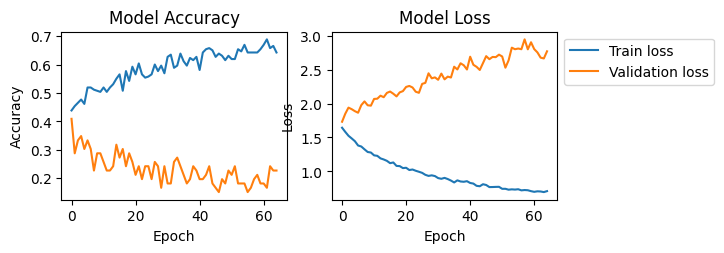

In [29]:
plt.subplot(221)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.subplot(222)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()


In [36]:
import random
import numpy as np 


# Choisissez un exemple aléatoire dans l'ensemble de test
index = random.randint(0, len(X_test) - 1)
input_test = np.expand_dims(X_test[index], axis=0)  # Convertir en forme (1, num_features) pour une prédiction unique

# Faites la prédiction
prediction = model.predict(input_test)

classe = np.argmax(prediction)

taux_confiance = max(prediction[0]) * 100
predicted_accord_name = label_encoder.inverse_transform([classe])[0]

print(f'Prédiction de classe : {classe}')
print(f'Accord prédit : {predicted_accord_name}')
print(f'Taux de confiance : {taux_confiance}%')

1/1 [==============================] - 0s 63ms/step
Prédiction de classe : 7
Accord prédit : Abaug
Taux de confiance : 84.20630097389221%


In [37]:
y_pred = model.predict(X_test)
pred = []
for i in range(len(y_pred)):
    pred.append(np.argmax(y_pred[i]))

count = 0
for i in range(len(pred)):
    if pred[i] == y_test[i]:
        count+=1

string = "Performance : " + str(count/len(y_test)*100) + "%"
print(string)


3/3 [==============================] - 0s 4ms/step
Performance : 29.268292682926827%
